1. Maximum of Brownin motion

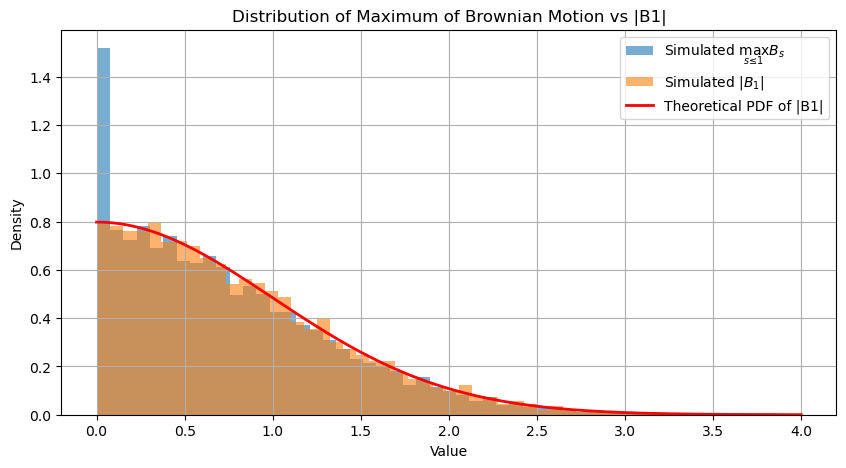

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Parameters
n_paths = 10000   # number of simulated Brownian paths
n_steps = 100     # number of time steps per path (step size = 0.01 for total time = 1)
dt = 1.0 / n_steps

# Simulate Brownian motion increments
dB = np.sqrt(dt) * np.random.randn(n_paths, n_steps)
B = np.cumsum(dB, axis=1)  # cumulative sum to form Brownian paths
B = np.hstack([np.zeros((n_paths, 1)), B])  # add starting point at 0

# Compute the maximum of each path
max_B = np.max(B, axis=1)

# Take |B1|, the absolute value of the final point
abs_B1 = np.abs(B[:, -1])

# Plot histograms of the two simulated distributions
plt.figure(figsize=(10,5))
plt.hist(max_B, bins=50, density=True, alpha=0.6, label=r"Simulated $\max_{s\leq 1} B_s$")
plt.hist(abs_B1, bins=50, density=True, alpha=0.6, label=r"Simulated $|B_1|$")

# Theoretical PDF of |B1| (folded normal distribution)
x = np.linspace(0, 4, 200)
pdf_absB1 = 2 * norm.pdf(x, loc=0, scale=1)  # distribution of |N(0,1)|
plt.plot(x, pdf_absB1, "r-", lw=2, label="Theoretical PDF of |B1|")

# Final plot settings
plt.title("Distribution of Maximum of Brownian Motion vs |B1|")
plt.xlabel("Value")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.show()


2. First Passage Time

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# ===== Settings =====
np.random.seed(42)
T = 10.0            # time horizon
dt = 0.01           # discretization
n_steps = int(T / dt)
n_paths = 10_000
level = 1.0         # hitting level

# ===== Simulate standard Brownian motion B_t =====
# Increments: N(0, dt), cumulative sum to get B_t, and prepend B_0 = 0
dW = np.random.normal(loc=0.0, scale=np.sqrt(dt), size=(n_paths, n_steps))
B = np.cumsum(dW, axis=1)
B = np.concatenate([np.zeros((n_paths, 1)), B], axis=1)   # shape (n_paths, n_steps+1)

# Time grid
t_grid = np.linspace(0.0, T, n_steps + 1)

# ===== First passage time tau to level 1, capped at T =====
# hit_mask[i, j] = True if path i has B_t >= 1 at time index j
hit_mask = (B >= level)

# Did the path ever hit within [0, T]?
hit_any = hit_mask.any(axis=1)

# First index where it hits (argmax trick: returns first True index; returns 0 if all False)
first_idx = hit_mask.argmax(axis=1)

# Tau^ = tau \wedge T
tau_cap = np.where(hit_any, t_grid[first_idx], T)

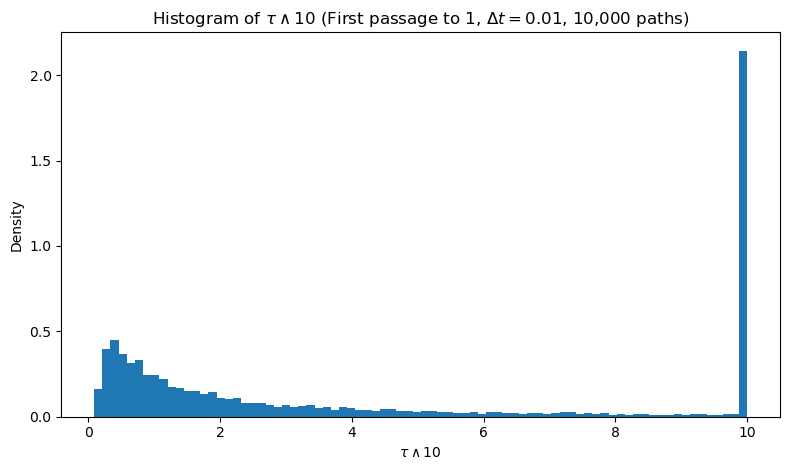

In [4]:
# ===== (a) Histogram of tau_cap =====
plt.figure(figsize=(8, 4.8))
plt.hist(tau_cap, bins=80, density=True)
plt.title(r"Histogram of $\tau \wedge 10$ (First passage to 1, $\Delta t=0.01$, $10{,}000$ paths)")
plt.xlabel(r"$\tau \wedge 10$")
plt.ylabel("Density")
plt.tight_layout()
plt.show()

In [5]:
# ===== (b) Estimate E[tau ∧ 10] =====
E_tau_cap = np.mean(tau_cap)

In [ ]:
# ===== (c) Proportion that never reach 1 in [0,10] =====
prop_never_reach = 1.0 - hit_any.mean()

print(f"Estimated E[τ ∧ 10] = {E_tau_cap:.4f}")
print(f"Proportion never reaching 1 in [0, 10]: {prop_never_reach:.4%}")

Estimated E[τ ∧ 10] = 4.3246
Proportion never reaching 1 in [0, 10]: 26.3900%


3. **Gambler’s ruin at French roulette** (biased simple random walk, $p=18/38$).


## 3) Gambler’s ruin at French roulette (biased simple random walk)

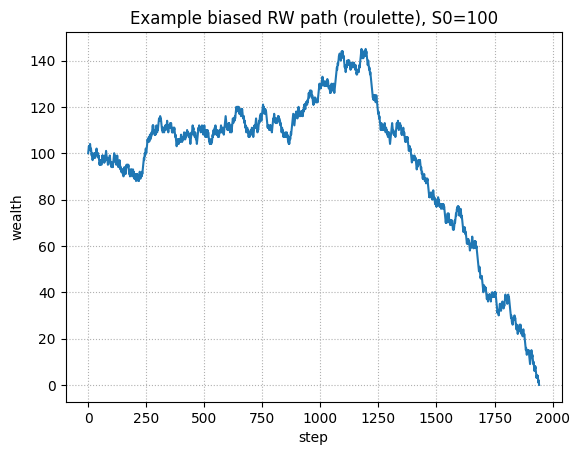

(4.4b) Estimated P_reach_200_before_0 | S0=100 (N=100): 0.000000


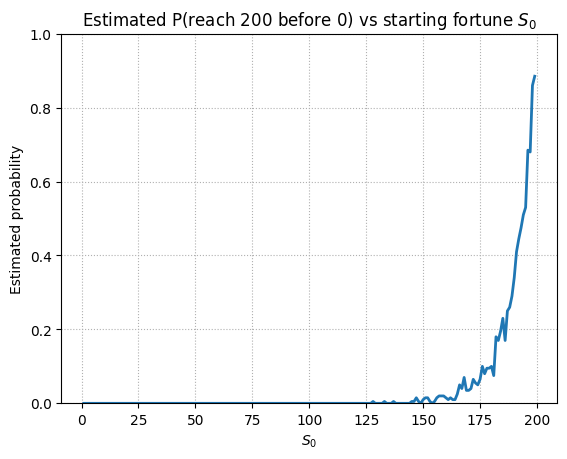

In [14]:
# Imports & global RNG helper
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass

def rng(seed: int):
    return np.random.default_rng(seed)
from dataclasses import dataclass
@dataclass
class Config:
    # Monte Carlo sizes for (4.4)
    n_paths_S0_eq_100: int = 100   # part (b)
    n_trials_per_S0: int   = 200   # part (c)
    p_up: float       = 18/38
    lower: int        = 0
    upper: int        = 200
    max_steps_rw: int = 5_000

    # Monte Carlo sizes for (4.4)
    n_paths_S0_eq_100: int = 100   # part (b)
    n_trials_per_S0: int   = 200

    seed: int = 42

CFG = Config()

def sample_rw_absorb(S0: int, p: float, lower: int, upper: int, max_steps: int, g) -> bool:
    S = S0
    for _ in range(max_steps):
        step = 1 if g.random() < p else -1
        S += step
        if S >= upper:
            return True
        if S <= lower:
            return False
    return False

g = rng(CFG.seed + 2)
p = CFG.p_up
upper, lower = CFG.upper, CFG.lower

S = 100
S_vals = [S]
for _ in range(CFG.max_steps_rw):
    S += 1 if g.random() < p else -1
    S_vals.append(S)
    if S <= lower or S >= upper:
        break
plt.figure()
plt.plot(S_vals)
plt.title('Example biased RW path (roulette), S0=100')
plt.xlabel('step'); plt.ylabel('wealth'); plt.grid(True, which='both', linestyle=':'); plt.show()

# (b) Probability to hit 200 before 0 from S0=100
g_b = rng(CFG.seed + 3)
hits = 0
for _ in range(CFG.n_paths_S0_eq_100):
    hits += sample_rw_absorb(100, p, lower, upper, CFG.max_steps_rw, g_b)
prob_from_100 = hits / CFG.n_paths_S0_eq_100
print(f"(4.4b) Estimated P_reach_200_before_0 | S0=100 (N={CFG.n_paths_S0_eq_100}): {prob_from_100:.6f}")

# (c) Probability vs starting fortune S0
S0_vals = np.arange(1, upper)
probs = np.zeros_like(S0_vals, dtype=float)
for i, S0 in enumerate(S0_vals):
    g_c = rng(CFG.seed + 1000 + i)
    hits = 0
    for _ in range(CFG.n_trials_per_S0):
        hits += sample_rw_absorb(S0, p, lower, upper, CFG.max_steps_rw, g_c)
    probs[i] = hits / CFG.n_trials_per_S0

plt.figure()
plt.plot(S0_vals, probs, linewidth=2)
plt.title('Estimated P(reach $200$ before $0$) vs starting fortune $S_0$')
plt.xlabel('$S_0$'); plt.ylabel('Estimated probability'); plt.ylim(0, 1)
plt.grid(True, which='both', linestyle=':'); plt.show()
